In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import broyden1
from scipy import optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
df = pd.read_csv('dataset.csv', index_col=0)
df.head()

,date,rConsumption,USGrowth,GDPDef,RFR,qt,year,GDPDef_p,RFR_Q,Rt,mt
0,1971-01-01,3156.978,1.080000,22.391,3.840000,1,1971,NaN,NaN,NaN,NaN
1,1971-04-01,3185.993,1.136667,22.685,4.250000,2,1971,0.013130,-0.002505,1.039339,0.937121
2,1971-07-01,3211.394,1.113333,22.916,5.010000,3,1971,0.010183,0.002342,0.969289,0.943936
3,1971-10-01,3264.679,1.113333,23.107,4.230000,4,1971,0.008335,0.002240,0.991665,0.896920
4,1972-01-01,3307.767,1.240000,23.458,3.436667,1,1972,0.015190,-0.006599,1.098582,0.915100


In [4]:
params = {'beta': 0.99, 'gamma':0}

## Problem 1

In [5]:
def est_gamma_1(gamma, p):
    mt = p['beta']* (df.rConsumption.pct_change()+1)**(-gamma)
    mt = mt.dropna()
    Rt = df.Rt.dropna()
    
    cov = np.cov(Rt,mt)[0,1]
    ERt = np.mean(Rt)
    Emt = np.mean(mt)
    
    return cov + ERt*Emt - 1

In [6]:

F1 = lambda gamma: est_gamma_1(gamma, params)
print('Coverged gamma value: ', broyden1(F1, 0.0001))

Coverged gamma value:  1.1880435856364957


This value doesn't seem too unreasonable.

## Problem 2

In [7]:
def est_gamma_2(gamma,p):
    mt = p['beta']* (df.rConsumption.pct_change()+1)**(-gamma)
    Emt = np.mean(mt.dropna())
    rf = np.mean(df.RFR_Q.dropna())

    return 1/Emt - 1 - rf

In [8]:
F2 = lambda gamma: est_gamma_2(gamma, params)
print('Converged gamma value: ', broyden1(F2, 10))

Converged gamma value:  -0.9198050509334023


This value is definitely too low

## Problem 3

In [9]:
def est_gmm(p, W=np.eye(2)):
    gmm_est = np.zeros(2)
    gamma = p[0]
    beta = p[1]
    
    mt = beta* (df.rConsumption.pct_change()+1)**(-gamma)
    mt = mt.dropna()
    Rt = df.Rt.dropna()

    gmm_est[0] = np.mean(beta* mt*(Rt) -1 )
    gmm_est[1] = np.mean(beta* mt *(1+ df.RFR_Q) -1)
    
    gmm = gmm_est.reshape(1, 2) @ W @ gmm_est.reshape(2, 1)
    return gmm[0][0]

In [12]:
p_guess = [1, 1]
F_GMM = lambda p: est_gmm(p)

p = opt.minimize(F_GMM, x0=p_guess)

In [13]:
p

      fun: 0.0001229371653878208
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([-2.15735417e-06, -5.47315176e-06])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([1.00000707, 0.99814196])

These values seem semi reasonable. A gamma value of 1 and a $\beta$ value of 0.998 isn't too unreasonable'

## Problem 4

In [47]:
betaG = np.linspace(.1,.99,30)
gammaG= np.linspace(1,50,30)
betaM, gammaM = np.meshgrid(betaG, gammaG)
assetP = np.zeros_like(betaM)

for i in range(30):
    for j in range(30):
        params['beta'] = betaM[i,j]
        gamma = gammaM[i,j]
        assetP[i,j] = est_gamma_1(gamma, params)+est_gamma_2(gamma, params)

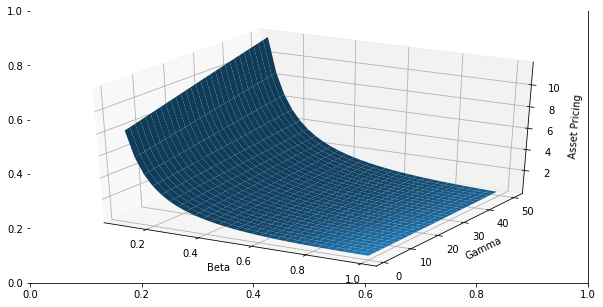

In [48]:
fig, ax = plt.subplots(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
                                  
ax.plot_surface(betaM, gammaM, assetP)
ax.set_xlabel('Beta')
ax.set_ylabel('Gamma')
ax.set_zlabel('Asset Pricing')
plt.show()